# MLBD - Assignment

## Import the libraries

In [ ]:
# Classic libraries in case we need them
import numpy as np
import pandas as pd
import datetime
import time
import matplotlib.pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets
import glob
import json



# Libraries used to print maps with information on it
import folium
import branca
import geopandas as gpd
from folium.plugins import HeatMap, HeatMapWithTime
from geopy.geocoders import ArcGIS
import pycountry
import requests
import altair as alt
from collections import defaultdict


# Spark package and functions
from pyspark import SparkConf, SparkContext, SparkFiles
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql.functions import *
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, LongType, ArrayType, Row, DoubleType

import findspark
findspark.init()

# Library to ignore minor warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
pip install pycountry

In [ ]:
pip install findspark

# Create the Spark Session

In [ ]:
# We first need to create a SparkSession
MAX_MEMORY = "5g"

spark = SparkSession.builder.config("spark.executor.memory", MAX_MEMORY).config("spark.driver.memory", MAX_MEMORY).getOrCreate()
sqlContext = SQLContext(spark)
spark

In [ ]:
#spark.stop()
#if Done

## Functions

In [ ]:
'''
This function is used to process the raw dataset in order to create another Spark DataFrame with the useful information.
for each row, we will only keep the id, the timestamp, the latitude, the longitude, the altitude, the country, the sensor name, the sensor id and the P1 and P2 values.
When a value is missing, we put the value -1. When both the values are missing, we drop the row afterwards

Input : The raw dataset (Spark DataFrame)
Output : The processed dataset in the format mentionned above (Spark DataFrame)
'''


def data_process (df) :
    df = df.withColumn("latitude", df.location.latitude.cast('float')).withColumn("longitude", df.location.longitude.cast('float')).withColumn("country", df.location.country).withColumn("sensor_id", df.sensor.id).withColumn("sensor_name", df.sensor.sensor_type['name'])
    df = df.withColumn('datavalues', explode('sensordatavalues'))
    df = df.withColumn('value_type', df.datavalues.value_type).drop('sensordatavalues')
    df = df.where((df.value_type == 'P1') | (df.value_type == 'P2'))
    df = df.withColumn('value', df.datavalues.value.cast('float'))
    df = df.drop('location', 'sampling_rate', 'sensor', 'datavalues')
    df_1 = df.where(df.value_type == 'P1').withColumnRenamed('value', 'P1').drop('value_type')
    df_2 = df.where(df.value_type == 'P2').withColumnRenamed('value', 'P2').drop('value_type')
    df = df_1.join(df_2, df_1.id == df_2.id).select(df_1.id, df_1.timestamp, df_1.latitude, df_1.longitude, df_1.country, df_1.sensor_id, df_1.sensor_name, df_1.P1, df_2.P2)

    return df

In [ ]:
def get_naturalearth_data():
    # URL for the Natural Earth low-resolution shapefile
    url = "https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip"

    # Local file path to store the downloaded data
    file_path = "ne_110m_admin_0_countries.zip"

    # Download the file if it doesn't exist locally
    import os
    if not os.path.exists(file_path):
        response = requests.get(url, stream=True)
        with open(file_path, "wb") as f:
            for chunk in response.iter_content(chunk_size=1024):
                if chunk:
                    f.write(chunk)

    # Read the shapefile using geopandas
    world = gpd.read_file(file_path)
    # Ensure 'continent' column exists, if not, create it
    if 'continent' not in world.columns:
        world['continent'] = ''  # Or assign a default value
    return world

In [ ]:
def plot_sensors():
    # Fetch data from the URL
    url = "https://data.sensor.community/static/v2/data.json"

    try:
        response = requests.get(url)
        response.raise_for_status()
        data = response.json()
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data: {e}")
        return

    # Define the schema for sensordatavalues
    schema = StructType([
        StructField("id", LongType(), True),
        StructField("timestamp", StringType(), True),
        StructField("location", StructType([
            StructField("latitude", StringType(), True),  # Changed to StringType
            StructField("longitude", StringType(), True),  # Changed to StringType
            StructField("country", StringType(), True)
        ]), True),
        StructField("sensor", StructType([
            StructField("id", LongType(), True),
            StructField("sensor_type", StructType([
                StructField("name", StringType(), True),
                StructField("id", LongType(), True)
            ]), True)
        ]), True),
        StructField("sensordatavalues", ArrayType(StructType([
            StructField("value_type", StringType(), True),
            StructField("value", StringType(), True)
        ])), True),
        StructField("sampling_rate", StringType(), True)
    ])

    # Create a Spark DataFrame with the defined schema
    df = spark.createDataFrame(data, schema=schema)

    # Cast latitude and longitude to float after DataFrame creation
    df = df.withColumn("latitude", df.location.latitude.cast('float'))\
           .withColumn("longitude", df.location.longitude.cast('float'))

    df = data_process(df)

    Sensor_position = df.select(df.latitude, df.longitude, df.country).distinct()

    #Instead of using geopandas.datasets, use geodatasets to get the path to 'naturalearth_lowres'
    #and then use geopandas.read_file to read the file at that path

    world = get_naturalearth_data()
    # Check the actual column names in your GeoDataFrame 'world'
    print(world.columns)
    # Assuming 'admin' is the column for country name and 'ISO_A3' for ISO 3 code
    gpd_world = world[['continent', 'NAME', 'ADM0_A3']]   # Updated with likely column names
    fig, ax = plt.subplots(figsize=(20,15))

    iso_a2 = []
    for i in range(len(gpd_world.values)) :
        A3 = gpd_world.values[i,-1]
        if A3 != '-99' :
            country = pycountry.countries.get(alpha_3 = A3)
            if type(country) != type(None) :
                iso_a2.append([gpd_world.values[i,0], gpd_world.values[i,1], country.alpha_2])
    gpd_world2 = gpd.GeoDataFrame(iso_a2, columns = ["continent", 'name', 'country'])

    pandas_df = Sensor_position.toPandas()

    pandas_df = gpd_world2.merge(pandas_df, on='country')

    gdf = gpd.GeoDataFrame(pandas_df, geometry=gpd.points_from_xy(pandas_df["longitude"], pandas_df["latitude"]), crs="epsg:4386")

    world.plot('continent', ax = ax, color='#e4e4e4')
    world.boundary.plot(ax = ax, color='black');
    gdf.plot(ax = ax)

Index(['featurecla', 'scalerank', 'LABELRANK', 'SOVEREIGNT', 'SOV_A3',
       'ADM0_DIF', 'LEVEL', 'TYPE', 'TLC', 'ADMIN',
       ...
       'FCLASS_ID', 'FCLASS_PL', 'FCLASS_GR', 'FCLASS_IT', 'FCLASS_NL',
       'FCLASS_SE', 'FCLASS_BD', 'FCLASS_UA', 'geometry', 'continent'],
      dtype='object', length=170)


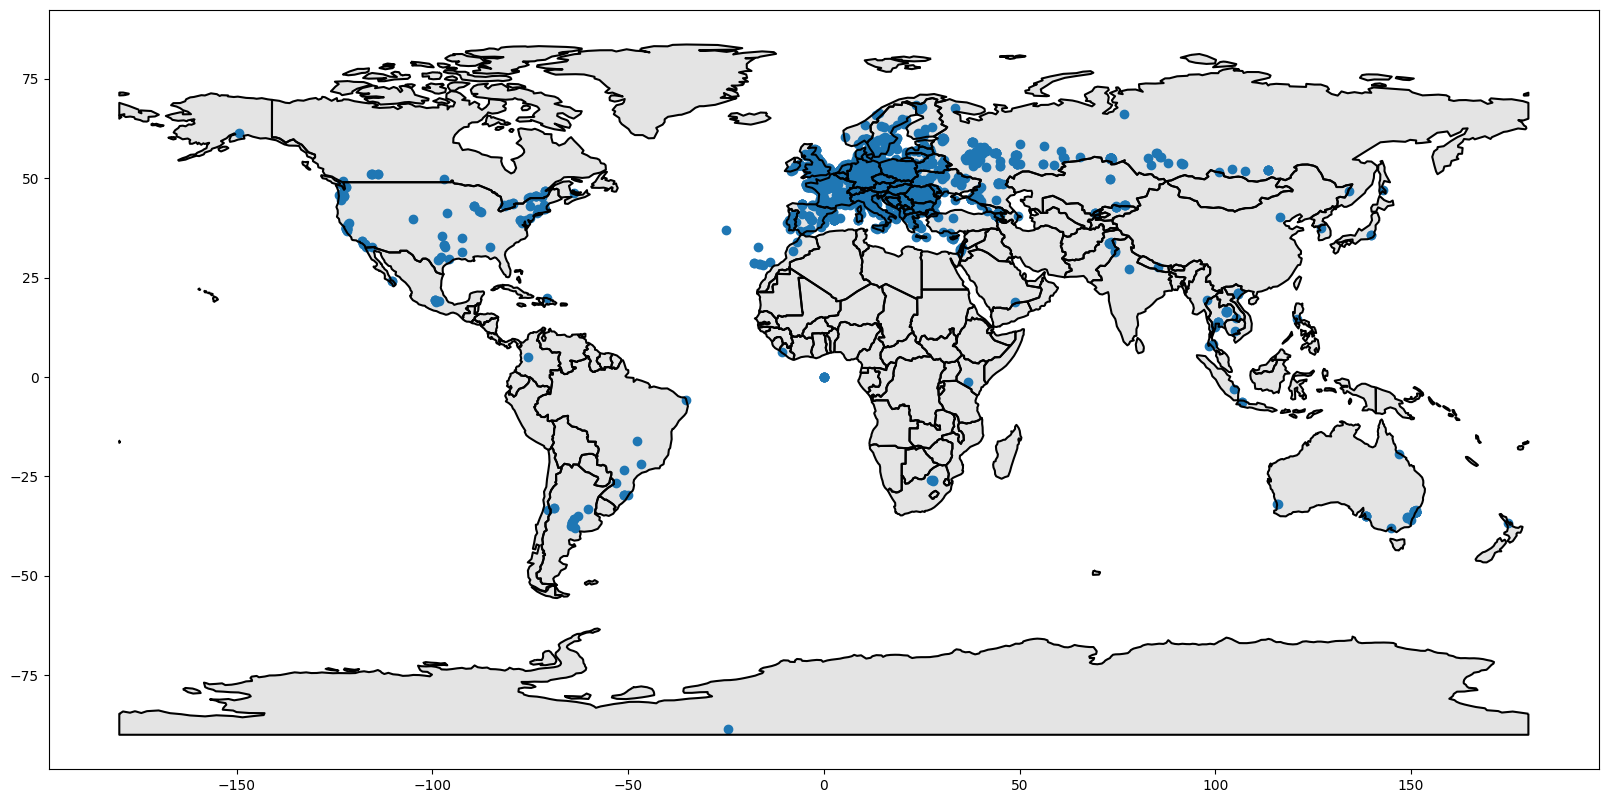

In [ ]:
plot_sensors()

### Task 1

In [ ]:
'''
This function determines the mean AQI for each country on the dataset. First we compute the mean of the P1 and P2 values for each country.
Because the input of this function has to be in the format of the output of the df_process function, we will need to handle the cases P1 = -1 or P2 = -1.
Given the average P1 and P2 values for each country, we can determine the AQI for this country.
We decided to take into account the ceil value of the mean values in case they are in the middle of two AQI values.

Input : The processed DataFrame obtained with the function 'df_process' (Spark DataFrame)
Output : A Spark DataFrame containing the country, the number of sensor in this country, the current mean P1 and P2 values and the current AQI value
'''

def compute_AQI_per_country(df_process) :
    # We first compute the average value of P1 and P2. We just take into account positive values of P1 and P2
    avgPerCountry1 = df_process.where(df_process.P1 >= 0).groupBy("country").avg('P1').withColumnRenamed('avg(P1)', 'mean_P1')
    avgPerCountry2 = df_process.where(df_process.P2 >= 0).groupBy("country").avg('P2').withColumnRenamed('avg(P2)', 'mean_P2')

    # We then need to join these two DataFrame.
    avgPerCountry = avgPerCountry1.join(avgPerCountry2, avgPerCountry1.country == avgPerCountry2.country).select(avgPerCountry1.country, avgPerCountry1.mean_P1, avgPerCountry2.mean_P2)
    # We then take the ceil value of each mean in case these values are between two AQI range.
    avgPerCountry = avgPerCountry.select(avgPerCountry.country, avgPerCountry.mean_P1, avgPerCountry.mean_P2, ceil('mean_P1'), ceil('mean_P2'))
    avgPerCountry = avgPerCountry.withColumnRenamed(avgPerCountry.columns[-2], 'ceil_mean_P1').withColumnRenamed(avgPerCountry.columns[-1], 'ceil_mean_P2')


    # We can then determine the AQI for each country
    # First we determine the AQI value given by P1 and P2
    avgPerCountry = avgPerCountry.select(avgPerCountry.country, avgPerCountry.mean_P1, avgPerCountry.mean_P2, \
                                         avgPerCountry.ceil_mean_P1, avgPerCountry.ceil_mean_P2, \
                                     when((0 <= avgPerCountry.ceil_mean_P1) & (avgPerCountry.ceil_mean_P1 <= 16), 1) \
                     .when((17 <= avgPerCountry.ceil_mean_P1) & (avgPerCountry.ceil_mean_P1 <= 33), 2) \
                     .when((34 <= avgPerCountry.ceil_mean_P1) & (avgPerCountry.ceil_mean_P1 <= 50), 3) \
                     .when((51 <= avgPerCountry.ceil_mean_P1) & (avgPerCountry.ceil_mean_P1 <= 58), 4) \
                     .when((59 <= avgPerCountry.ceil_mean_P1) & (avgPerCountry.ceil_mean_P1 <= 66), 5) \
                     .when((67 <= avgPerCountry.ceil_mean_P1) & (avgPerCountry.ceil_mean_P1 <= 75), 6) \
                     .when((76 <= avgPerCountry.ceil_mean_P1) & (avgPerCountry.ceil_mean_P1 <= 83), 7) \
                     .when((84 <= avgPerCountry.ceil_mean_P1) & (avgPerCountry.ceil_mean_P1 <= 91), 8) \
                     .when((92 <= avgPerCountry.ceil_mean_P1) & (avgPerCountry.ceil_mean_P1 <= 100), 9)
                     .otherwise(10), \
                            when((0 <= avgPerCountry.ceil_mean_P2) & (avgPerCountry.ceil_mean_P2 <= 11), 1) \
                     .when((12 <= avgPerCountry.ceil_mean_P2) & (avgPerCountry.ceil_mean_P2 <= 23), 2) \
                     .when((24 <= avgPerCountry.ceil_mean_P2) & (avgPerCountry.ceil_mean_P2 <= 35), 3) \
                     .when((36 <= avgPerCountry.ceil_mean_P2) & (avgPerCountry.ceil_mean_P2 <= 41), 4) \
                     .when((42 <= avgPerCountry.ceil_mean_P2) & (avgPerCountry.ceil_mean_P2 <= 47), 5) \
                     .when((48 <= avgPerCountry.ceil_mean_P2) & (avgPerCountry.ceil_mean_P2 <= 53), 6) \
                     .when((54 <= avgPerCountry.ceil_mean_P2) & (avgPerCountry.ceil_mean_P2 <= 58), 7) \
                     .when((59 <= avgPerCountry.ceil_mean_P2) & (avgPerCountry.ceil_mean_P2 <= 64), 8) \
                     .when((65 <= avgPerCountry.ceil_mean_P2) & (avgPerCountry.ceil_mean_P2 <= 70), 9)
                     .otherwise(10))

    avgPerCountry = avgPerCountry.withColumnRenamed(avgPerCountry.columns[-2], 'AQI_1').withColumnRenamed(avgPerCountry.columns[-1], 'AQI_2')

    # Then we can save only the highest value of AQI
    AQI = avgPerCountry.select(avgPerCountry.country, avgPerCountry.mean_P1, avgPerCountry.mean_P2, \
                   when(avgPerCountry.AQI_1 < avgPerCountry.AQI_2, avgPerCountry.AQI_2).otherwise(avgPerCountry.AQI_1))

    AQI = AQI.withColumnRenamed(AQI.columns[-1], 'AQI')

    # We add the number of sensor per country for more information about the AQI
    sensorPerCountry = df_process.groupBy('country').count()
    sensorPerCountry = sensorPerCountry.withColumnRenamed('count', 'nb_sensor')

    AQI = AQI.join(sensorPerCountry, AQI.country == sensorPerCountry.country).select(AQI.country, sensorPerCountry.nb_sensor, AQI.mean_P1, AQI.mean_P2, AQI.AQI)

    return AQI

In [ ]:
'''
This function will compute the average air quality index improvement over the previous 24 hours using the two most recent files in our data base.
Input : The data of the day we are studying as well as the previous one (Spark DataFrame). They sould be in the format given by the output of the function 'compute_AQI_per_country'
Output : A Spark DataFrame with the country, the number of sensor per country, the current P1 and P2 value, the current average AQI and the AQI improvement over the previous 24 hours
'''

def AQI_improvementPerCountry(df_today, df_yesterday) :
    # We first add the average AQI for the previous day to the DataFrame of the present day
    df_yesterday2 = df_yesterday.withColumnRenamed(df_yesterday.columns[-1], 'AQI_yesterday')

    improvement = df_today.join(df_yesterday2, df_today.country == df_yesterday2.country).select(df_today.country, df_today.nb_sensor, df_today.mean_P1, df_today.mean_P2, df_today.AQI, df_yesterday2.AQI_yesterday)

    # Then we determine the improvement. We compute it so that the greater the value is, the better the improvement is.
    # A positive value means that the current AQI is lower than the previous 24 hours.
    improvement = improvement.select(improvement.country, improvement.nb_sensor, improvement.mean_P1, improvement.mean_P2, improvement.AQI, improvement.AQI_yesterday, improvement.AQI_yesterday - improvement.AQI)

    improvement = improvement.withColumnRenamed(improvement.columns[-1], 'AQI_improvement')

    # We can drop the column with the AQI of the previous day as we won't need it anymore
    improvement = improvement.drop('AQI_yesterday')

    # We order the DataFrame according to the AQI improvement
    improvement = improvement.orderBy(improvement.AQI_improvement.desc(), 'AQI', 'country')

    # We add a column with the rank of the country
    improvement = improvement.withColumn('rank', monotonically_increasing_id()+1)


    improvement.show(10)
    return improvement

In [ ]:
'''
This function define a html popup that will be used to print informations on a map for the task 1
Input : The row (int), and the dataframe where the information are stored (pandas DataFrame)
Output : A html function to add information to the popup window
'''

def popup_html_Q1(row, df_map):
    i = row
    country = df_map['country'].iloc[i]


    country2 = pycountry.countries.get(alpha_2 = country)
    country2 = country2.name

    nb_sensor = df_map['nb_sensor'].iloc[i]
    P1 = df_map['mean_P1'].iloc[i]
    P2 = df_map['mean_P2'].iloc[i]
    rank = df_map['rank'].iloc[i]

    AQI = df_map['AQI'].iloc[i]
    AQI_improvement = df_map['AQI_improvement'].iloc[i]

    left_col_color = "#19a7bd"
    right_col_color = "#f2f0d3"

    html = """<!DOCTYPE html>
<html>
<head>
<h4 style="margin-bottom:10"; width="200px">{}</h4>""".format(country2) + """
</head>
    <table style="height: 126px; width: 350px;">
<tbody>
<tr>
<td style="background-color: """+ left_col_color +""";"><span style="color: #ffffff;">Country code</span></td>
<td style="width: 150px;background-color: """+ right_col_color +""";">{}</td>""".format(country) + """
</tr>
<tr>
<td style="background-color: """+ left_col_color +""";"><span style="color: #ffffff;">Rank of the country</span></td>
<td style="width: 150px;background-color: """+ right_col_color +""";">{}</td>""".format(rank) + """
</tr>
<tr>
<td style="background-color: """+ left_col_color +""";"><span style="color: #ffffff;">Number of sensors</span></td>
<td style="width: 150px;background-color: """+ right_col_color +""";">{}</td>""".format(nb_sensor) + """
</tr>
<tr>
<td style="background-color: """+ left_col_color +""";"><span style="color: #ffffff;">Average P1</span></td>
<td style="width: 150px;background-color: """+ right_col_color +""";">{}</td>""".format(P1) + """
</tr>
<tr>
<td style="background-color: """+ left_col_color +""";"><span style="color: #ffffff;">Average P2</span></td>
<td style="width: 150px;background-color: """+ right_col_color +""";">{}</td>""".format(P2) + """
</tr>
<tr>
<td style="background-color: """+ left_col_color +""";"><span style="color: #ffffff;">Current AQI</span></td>
<td style="width: 150px;background-color: """+ right_col_color +""";">{}</td>""".format(AQI) + """
</tr>
<tr>
<td style="background-color: """+ left_col_color +""";"><span style="color: #ffffff;">AQI improvement</span></td>
<td style="width: 150px;background-color: """+ right_col_color +""";">{}</td>""".format(AQI_improvement) + """
</tr>
</tbody>
</table>
</html>
"""
    return html

In [ ]:
!pip install geopy
import geopy

def print_map_Q1(df_process):
    # We first create the map
    # Use the correct case for "Stamen Terrain" tiles
    # We first create the map
    # Use the correct case for "Stamen Terrain" tiles and include attribution
    world_map = folium.Map(
        location=[0, 0],
        tiles="CartoDB positron",  # Change to a basemap with clear country borders, like "OpenStreetMap" or "CartoDB positron"
        attr="Map tiles by CartoDB, under CC BY 3.0. Data by OpenStreetMap, under ODbL.",
        zoom_start=2,
    )
    # We convert the DataFrame to a pandas DataFrame which will be used in the 'popup_html_Q1' function
    df_map = df_process.toPandas()

    # This command is used to find afterwards the full name of each country
    nom = ArcGIS()

    # This list will be used to print a heatmap with the current AQI value
    heatmap = []

    # For this question, we are interested in the top 10 countries in term of AQI improvement
    for i in range(10):

        # Using this command, we can find the full name of the country
        country = pycountry.countries.get(alpha_2=df_map["country"].iloc[i])

        # We can find the coordinates of the center of the country with these lines
        if country.alpha_2 == "TW":
            m = nom.geocode(country.alpha_2)
        else:
            m = nom.geocode(country.name)

        # We need to create a DataFrame with a column giving the ISO3 code name for the country as well as its rank
        if i == 0:
            list_countries = pd.DataFrame([[country.alpha_3, i + 1]], columns=["iso_a3", "Rank"])

        else:
            list_countries.loc[len(list_countries)] = [country.alpha_3, i + 1]

        # Coordinates of the center of the country
        latitude = m.latitude
        longitude = m.longitude

        # These lines define the popup window that will be displayed on the markers on the map
        html = popup_html_Q1(i, df_map)
        iframe = branca.element.IFrame(html=html, width=510, height=280)
        popup = folium.Popup(folium.Html(html, script=True), width=510, height=280)

        # We add a marker to the map for the top 10 countries. We also use the popup window to give more informations
        folium.Marker(
        location=[float(latitude), float(longitude)],
        popup=popup,
        # Change the icon here
        icon=folium.Icon(color="green", icon="info-sign", prefix="fa"),
    ).add_to(world_map)
    # This part use geopandas to highlight the top 10 countries
    #Instead of using geopandas.datasets, use geodatasets to get the path to 'naturalearth_lowres'
    #and then use geopandas.read_file to read the file at that path
        # This part use geopandas to highlight the top 10 countries
    world = get_naturalearth_data()[['NAME', 'ADM0_A3', 'geometry']]  # Access existing columns 'NAME', 'ADM0_A3'

    # We merge the GeoPandas DataFrame with our new one
    gdf_df = world.merge(list_countries, left_on='ADM0_A3', right_on='iso_a3') # merging on the same columns
    gdf_df = gdf_df.sort_values(by=['Rank'])
    gdf_df = gdf_df.reset_index(drop=True)

    # Now we will define a colormap in order to give a specific color to each country according to its rank
    steps=11
    index=[i for i in range(1,11)]
    colormap = branca.colormap.LinearColormap(colors = ['green', 'red'], vmin=1, vmax=10).to_step(index=index)
    gradient_map=defaultdict(dict)
    for i in range(steps):
        gradient_map[i] = colormap.rgb_hex_str(i)

    Countries = folium.FeatureGroup(name='Top 10 countries', show=False)

    colormap.caption = 'Ranking of the country'
    colormap.add_to(world_map)
    folium.GeoJson(
        get_naturalearth_data(),
        name="World Countries",
        style_function=lambda x: {"fillColor": "transparent", "color": "black", "weight": 1},  # Change style_function to give a transparent fill to world map
    ).add_to(world_map)

    # Display the layer on the map
    gdf_df.explore(
        column="Rank",
        cmap=colormap,
        m=Countries,
        legend=False,
        tooltip=False,
        color=gradient_map,
        style_kwds={"fillOpacity": 0.5},  # Reduced fillOpacity for better viewing of underlying map
    )


    # This for loop will create the histograms
    for i in range (len(df_map)) :
        # Using this command, we can find the full name of the country
        country = pycountry.countries.get(alpha_2=df_map['country'].iloc[i])

        # We can find the coordinates of the center of the country with these lines
        if country.alpha_2 == 'TW' :
            m = nom.geocode(country.alpha_2)
        else :
            m = nom.geocode(country.name)


        # Coordinates of the center of the country
        latitude = m.latitude
        longitude = m.longitude

        # Ensure AQI values are within a suitable range for the heatmap
        heatmap.append([latitude, longitude, float(df_map['AQI'].iloc[i]) / 10])  # Convert AQI to float and normalize

    # We define the Heatmap and add it to the map
    Heat_map = folium.FeatureGroup(name='Heat map', show=True)  # Change show=False to show=True to display the heatmap by default

    hm = HeatMap(np.array(heatmap),
            min_opacity=0.4,
            blur = 18,
            show = True  # Change show=False to show=True to display the heatmap without relying on layer controls
           )

    # These lines will add the heatmap to the map and give control to the user whether to show the Heat map or not
    Heat_map.add_child(hm)
    world_map.add_child(Heat_map)
    world_map.add_child(Countries)

    world_map.add_child(folium.LayerControl())


    # We can return the map
    return world_map

In [ ]:
from pyspark.sql.functions import col, udf
from pyspark.sql.types import StringType
import pycountry

In [ ]:
'''
This function processes the data to find the top 10 countries in term of Air Quality Index improvement over the previous 24 hours.
This function will use the two last days in the database in order to determine the top 10 countries in term of AQI improvement over these two days
It will then display the results as a table and a map with differents layers


Input : None
Output : None, this function will print and show the useful tables and maps
'''

def question_1() :
    start_task = time.time()

    # Fetch data from the URLs
    url_today = "https://data.sensor.community/static/v2/data.json"  # Using the 5-minute data for testing
    url_yesterday = "https://data.sensor.community/static/v2/data.1h.json"

    try:
        response_today = requests.get(url_today)
        response_today.raise_for_status()  # Raise an exception for bad status codes
        data_today = response_today.json()

        response_yesterday = requests.get(url_yesterday)
        response_yesterday.raise_for_status()
        data_yesterday = response_yesterday.json()
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data: {e}")
        return


    # Define the schema for sensordatavalues
    schema = StructType([
        StructField("id", LongType(), True),
        StructField("timestamp", StringType(), True),
        StructField("location", StructType([
            StructField("latitude", StringType(), True),
            StructField("longitude", StringType(), True),
            StructField("country", StringType(), True)
        ]), True),
        StructField("sensor", StructType([
            StructField("id", LongType(), True),
            StructField("sensor_type", StructType([
                StructField("name", StringType(), True),
                StructField("id", LongType(), True)
            ]), True)
        ]), True),
        StructField("sensordatavalues", ArrayType(StructType([
            StructField("value_type", StringType(), True),
            StructField("value", StringType(), True)  # Use StringType for 'value'
        ])), True),
        StructField("sampling_rate", StringType(), True)
    ])

    # Create Spark DataFrames with the defined schema
    df_today = spark.createDataFrame(data_today, schema=schema)
    df_yesterday = spark.createDataFrame(data_yesterday, schema=schema)

    # Cast latitude and longitude to float after DataFrame creation
    df_today = df_today.withColumn("latitude", df_today.location.latitude.cast('float'))\
                   .withColumn("longitude", df_today.location.longitude.cast('float'))
    df_yesterday = df_yesterday.withColumn("latitude", df_yesterday.location.latitude.cast('float'))\
                   .withColumn("longitude", df_yesterday.location.longitude.cast('float'))

    print("Processing data from the following URLs:")
    print("    - Today:", url_today)
    print("    - Yesterday:", url_yesterday)

    # Then, we call the previously defined functions to process our data and find the top 10 countries in term of AQI improvement over the previous 24 hours
    AQI_today = compute_AQI_per_country(data_process(df_today))


    AQI_yesterday = compute_AQI_per_country(data_process(df_yesterday))

    # This function can determine the AQI improvement for each country and it will print out a table
    improvement_AQI = AQI_improvementPerCountry(AQI_today, AQI_yesterday)

    print('Creating the map ...\n')
    # We then print a map with markers on placed on the top 10 countries given by the previous function call
    map_Q1 = print_map_Q1(improvement_AQI)

    print("The map shows us the location of these 10 countries as well as some informations about the current situation.\nIt is also possible to display different layers using the panel on the top right of the window : ")
    print("- A heat map of the current AQI value for each of all of th countries ")
    print(" - A layer highlighting the top 10 countries with color according to its rank. The colorbar legend corresponds to this layer")

    display(map_Q1)

    end_task = time.time()
    print(f'It took {end_task-start_task} seconds to do this task')
    improvement_AQI = AQI_improvementPerCountry(AQI_today, AQI_yesterday)

    def get_country_name(country_code):
        try:
            country = pycountry.countries.get(alpha_2=country_code)
            return country.name
        except:
            return None  # Handle cases where country code is not found

# Register the UDF
    get_country_name_udf = udf(get_country_name, StringType())

# Get top 5 countries and add country name column
    top_5_countries = improvement_AQI.limit(5).withColumn(
        "country_name", get_country_name_udf(col("country"))
    ).select(
        "country", "country_name", "nb_sensor", "mean_P1", "mean_P2", "AQI", "AQI_improvement", "rank"  # Reorder columns here
    ).toPandas()

# Get worst 5 countries and add country name column
    worst_5_countries = improvement_AQI.orderBy(
        col("AQI_improvement").asc()
    ).limit(5).withColumn(
        "country_name", get_country_name_udf(col("country"))
    ).select(
        "country", "country_name", "nb_sensor", "mean_P1", "mean_P2", "AQI", "AQI_improvement", "rank"  # Reorder columns here
    ).toPandas()

# Display tables
    print("Top 5 Countries with Best AQI Improvement:")
    display(top_5_countries)

    print("\nWorst 5 Countries with Least AQI Improvement:")
    display(worst_5_countries)


In [ ]:
!pip install mapclassify

### Task 2

In [ ]:
'''
This function will create clusters given the latitude and the longitude of each sensor in a list of DataFrame.

Input : The number of clusters we want to create (int), a list of all the DataFrames of interest. The DataFrames should be in the format of the output of the function 'data_process'
Output : The transformed DataFrame list : each DataFrame will have a new column corresponding to its cluster prediction and A Spark DataFrame with all the sensors coordinates and the cluster associated with all the coordinates
'''

def create_cluster(nb_cluster, df_list) :
    # We first create a 'features' column that will be used to create our clusters
    vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")

    # Using the list of DataFrame, we will create a new DataFrame that store the location of each distinct sensors that appeared in the period we study
    for i in range(len(df_list)) :
        df_list[i] = vecAssembler.transform(df_list[i])

        if i == 0 :
            df_cluster = df_list[i].select('latitude', 'longitude', 'features').distinct()
        else :
            df_cluster = df_cluster.union(df_list[i].select('latitude', 'longitude', 'features').distinct()).distinct()


    df_cluster = spark.createDataFrame(df_cluster.rdd, schema = df_cluster.schema)


    # We create our model
    kmeans = KMeans(k=nb_cluster, seed=12, maxIter=10)
    model = kmeans.fit(df_cluster.select('features'))


    # We will add to each row the location of the center of the corresponding cluster
    center = []
    centers = model.clusterCenters()
    for i in range (len(centers)) :
        row = centers[i]
        center.append([i,float(np.round(float(row[0]),2)), float(np.round(float(row[1]),2))])


    cluster_centers = spark.createDataFrame(center, ['cluster_number', 'latitude', 'longitude'])
    vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="cluster_center")
    cluster_centers = vecAssembler.transform(cluster_centers)

    df_cluster = model.transform(df_cluster)

    # We transform our data given the cluster model and select the useful columns
    for i in range (len(df_list)) :

        df_list[i] = model.transform(df_list[i])
        df_list[i] = df_list[i].withColumnRenamed("prediction", "cluster_number")


        # For each DataFrame, we add the cluster center as a new column
        df_list[i] = df_list[i].join(cluster_centers, df_list[i].cluster_number == cluster_centers.cluster_number).select(df_list[i].cluster_number, cluster_centers.cluster_center, df_list[i].id, df_list[i].timestamp, df_list[i].latitude, df_list[i].longitude, df_list[i].country, df_list[i].sensor_id, df_list[i].sensor_name, df_list[i].P1, df_list[i].P2)

    return df_list, df_cluster

In [ ]:
'''
This function determine the mean AQI for each cluster on the dataset. First we compute the mean of the P1 and P2 values for each cluster.
Because the input of this function has to be in the format of the output of the df_process function, we will need to handle the case P1 = -1 or P2 = -1.
Given the average P1 and P2 values for each cluster, we can determine the AQI for this country.
We decided to take into account the ceil value of the mean values in case they are in the middle of two AQI values.

Input : The processed DataFrame obtained with the function 'df_process' (Spark DataFrame)
Output : A Spark DataFrame containing the country, the current mean P1 and P2 values and the current AQI value
'''

def compute_AQI_per_cluster(df_process) :
    # We first compute the average value of P1 and P2. We just take into account positive values
    avgPerCluster1 = df_process.where(df_process.P1 >= 0).groupBy("cluster_number").avg('P1').withColumnRenamed('avg(P1)', 'mean_P1')
    avgPerCluster2 = df_process.where(df_process.P2 >= 0).groupBy("cluster_number").avg('P2').withColumnRenamed('avg(P2)', 'mean_P2')

    # We then need to join these two DataFrame
    avgPerCluster = avgPerCluster1.join(avgPerCluster2, avgPerCluster1.cluster_number == avgPerCluster2.cluster_number).select(avgPerCluster1.cluster_number, avgPerCluster1.mean_P1, avgPerCluster2.mean_P2)
    avgPerCluster = avgPerCluster.join(df_process, avgPerCluster1.cluster_number == df_process.cluster_number).select(avgPerCluster1.cluster_number, df_process.cluster_center, avgPerCluster1.mean_P1, avgPerCluster2.mean_P2)

    # Some sensors data are stored on two lines on the raw data set. We make sure that each sensor only appear once.
    avgPerCluster = avgPerCluster.dropDuplicates()

    # We then take the ceil value of each mean in case these values are between two AQI range.
    avgPerCluster = avgPerCluster.select(avgPerCluster.cluster_number, avgPerCluster.cluster_center, avgPerCluster.mean_P1, avgPerCluster.mean_P2, ceil('mean_P1'), ceil('mean_P2'))
    avgPerCluster = avgPerCluster.withColumnRenamed(avgPerCluster.columns[-2], 'ceil_mean_P1').withColumnRenamed(avgPerCluster.columns[-1], 'ceil_mean_P2')


    # We can then determine the AQI for each country
    # First we determine the AQI value given by P1 and P2
    avgPerCluster = avgPerCluster.select(avgPerCluster.cluster_number, avgPerCluster.cluster_center, avgPerCluster.mean_P1, avgPerCluster.mean_P2, \
                                         avgPerCluster.ceil_mean_P1, avgPerCluster.ceil_mean_P2, \
                                     when((0 <= avgPerCluster.ceil_mean_P1) & (avgPerCluster.ceil_mean_P1 <= 16), 1) \
                     .when((17 <= avgPerCluster.ceil_mean_P1) & (avgPerCluster.ceil_mean_P1 <= 33), 2) \
                     .when((34 <= avgPerCluster.ceil_mean_P1) & (avgPerCluster.ceil_mean_P1 <= 50), 3) \
                     .when((51 <= avgPerCluster.ceil_mean_P1) & (avgPerCluster.ceil_mean_P1 <= 58), 4) \
                     .when((59 <= avgPerCluster.ceil_mean_P1) & (avgPerCluster.ceil_mean_P1 <= 66), 5) \
                     .when((67 <= avgPerCluster.ceil_mean_P1) & (avgPerCluster.ceil_mean_P1 <= 75), 6) \
                     .when((76 <= avgPerCluster.ceil_mean_P1) & (avgPerCluster.ceil_mean_P1 <= 83), 7) \
                     .when((84 <= avgPerCluster.ceil_mean_P1) & (avgPerCluster.ceil_mean_P1 <= 91), 8) \
                     .when((92 <= avgPerCluster.ceil_mean_P1) & (avgPerCluster.ceil_mean_P1 <= 100), 9)
                     .otherwise(10), \
                            when((0 <= avgPerCluster.ceil_mean_P2) & (avgPerCluster.ceil_mean_P2 <= 11), 1) \
                     .when((12 <= avgPerCluster.ceil_mean_P2) & (avgPerCluster.ceil_mean_P2 <= 23), 2) \
                     .when((24 <= avgPerCluster.ceil_mean_P2) & (avgPerCluster.ceil_mean_P2 <= 35), 3) \
                     .when((36 <= avgPerCluster.ceil_mean_P2) & (avgPerCluster.ceil_mean_P2 <= 41), 4) \
                     .when((42 <= avgPerCluster.ceil_mean_P2) & (avgPerCluster.ceil_mean_P2 <= 47), 5) \
                     .when((48 <= avgPerCluster.ceil_mean_P2) & (avgPerCluster.ceil_mean_P2 <= 53), 6) \
                     .when((54 <= avgPerCluster.ceil_mean_P2) & (avgPerCluster.ceil_mean_P2 <= 58), 7) \
                     .when((59 <= avgPerCluster.ceil_mean_P2) & (avgPerCluster.ceil_mean_P2 <= 64), 8) \
                     .when((65 <= avgPerCluster.ceil_mean_P2) & (avgPerCluster.ceil_mean_P2 <= 70), 9)
                     .otherwise(10))

    avgPerCluster = avgPerCluster.withColumnRenamed(avgPerCluster.columns[-2], 'AQI_1').withColumnRenamed(avgPerCluster.columns[-1], 'AQI_2')

    # Then we can save only the highest value of AQI
    AQI = avgPerCluster.select(avgPerCluster.cluster_number, avgPerCluster.cluster_center, avgPerCluster.mean_P1, avgPerCluster.mean_P2, \
                   when(avgPerCluster.AQI_1 < avgPerCluster.AQI_2, avgPerCluster.AQI_2).otherwise(avgPerCluster.AQI_1))

    AQI = AQI.withColumnRenamed(AQI.columns[-1], 'AQI')

    # We add the number of sensor per country for more information about the AQI
    sensorPerCluster = df_process.groupBy('cluster_number').count()
    sensorPerCluster = sensorPerCluster.withColumnRenamed('count', 'nb_sensor')

    AQI = AQI.join(sensorPerCluster, AQI.cluster_number == sensorPerCluster.cluster_number).select(AQI.cluster_number, AQI.cluster_center, sensorPerCluster.nb_sensor, AQI.mean_P1, AQI.mean_P2, AQI.AQI)

    # We order the DataFrame to show to lower value of AQI Improvement.
    AQI = AQI.orderBy('AQI', 'cluster_number')

    return AQI

In [ ]:
'''
This function will compute the average air quality index improvement over the previous 24 hours in order to determine the top 50 clusters in term of improvement
Input : The data of the day we are studying as well as the previous one (Spark DataFrame). They sould be in the format given by the output of the function 'compute_AQI_per_cluster'
Output : A Spark DataFrame with the cluster number, the center of this cluster, the number of sensor per cluster, the current P1 and P2 value, the current average AQI and the AQI improvement over the previous 24 hours
'''


def AQI_improvementPerCluster(df_today, df_yesterday) :
    # We first add the average AQI for the previous day to the DataFrame of the present day
    df_yesterday2 = df_yesterday.withColumnRenamed(df_yesterday.columns[-1], 'AQI_yesterday')

    improvement = df_today.join(df_yesterday2, df_today.cluster_number == df_yesterday2.cluster_number).select(df_today.cluster_number, df_today.cluster_center, df_today.nb_sensor, df_today.mean_P1, df_today.mean_P2, df_today.AQI, df_yesterday2.AQI_yesterday)

    # Then we determine the improvement. We compute it so that the greater the value is, the better the improvement is.
    # A positive value means that the current AQI is lower than the previous 24 hours.
    improvement = improvement.select(improvement.cluster_number, improvement.cluster_center, improvement.nb_sensor, improvement.mean_P1, improvement.mean_P2, improvement.AQI, improvement.AQI_yesterday, improvement.AQI_yesterday - improvement.AQI)

    improvement = improvement.withColumnRenamed(improvement.columns[-1], 'AQI_improvement')

    # We can drop the column with the AQI of the previous day as we won't need it anymore
    improvement = improvement.drop('AQI_yesterday')

    # We order the DataFrame according to the AQI improvement. The higher the value is, the better the improvement is
    improvement = improvement.orderBy(improvement.AQI_improvement.desc(), 'AQI')

    # Once the DataFrame is sorted, we add a new column that corresponds to the rank of the cluster
    improvement = improvement.withColumn('rank', monotonically_increasing_id()+1)

    improvement.show(50)
    return improvement

In [ ]:
'''
Thid function define a html popup that will be used to print informations on a map for the task 2
Input : The row (int), and the dataframe where the information are stored (pandas DataFrame)
Output : A html function to add information to the popup window
'''

def popup_html_Q2(row, df_map):
    i = row
    cluster = df_map['cluster_number'].iloc[i]
    cluster = 'Cluster n°' + str(cluster)
    cluster_center = df_map['cluster_center'].iloc[i]
    nb_sensor = df_map['nb_sensor'].iloc[i]
    Rank = df_map['rank'].iloc[i]
    P1 = df_map['mean_P1'].iloc[i]
    P2 = df_map['mean_P2'].iloc[i]

    AQI = df_map['AQI'].iloc[i]
    AQI_improvement = df_map['AQI_improvement'].iloc[i]

    left_col_color = "#19a7bd"
    right_col_color = "#f2f0d3"

    html = """<!DOCTYPE html>
<html>
<head>
<h4 style="margin-bottom:10"; width="200px">{}</h4>""".format(cluster) + """
</head>
    <table style="height: 126px; width: 350px;">
<tbody>
<tr>
<td style="background-color: """+ left_col_color +""";"><span style="color: #ffffff;">Rank of the cluster</span></td>
<td style="width: 150px;background-color: """+ right_col_color +""";">{}</td>""".format(Rank) + """
</tr>
<tr>
<td style="background-color: """+ left_col_color +""";"><span style="color: #ffffff;">Number of sensors</span></td>
<td style="width: 150px;background-color: """+ right_col_color +""";">{}</td>""".format(nb_sensor) + """
</tr>
<tr>
<td style="background-color: """+ left_col_color +""";"><span style="color: #ffffff;">Average P1</span></td>
<td style="width: 150px;background-color: """+ right_col_color +""";">{}</td>""".format(P1) + """
</tr>
<tr>
<td style="background-color: """+ left_col_color +""";"><span style="color: #ffffff;">Average P2</span></td>
<td style="width: 150px;background-color: """+ right_col_color +""";">{}</td>""".format(P2) + """
</tr>
<tr>
<td style="background-color: """+ left_col_color +""";"><span style="color: #ffffff;">Current AQI</span></td>
<td style="width: 150px;background-color: """+ right_col_color +""";">{}</td>""".format(AQI) + """
</tr>
<tr>
<td style="background-color: """+ left_col_color +""";"><span style="color: #ffffff;">AQI improvement</span></td>
<td style="width: 150px;background-color: """+ right_col_color +""";">{}</td>""".format(AQI_improvement) + """
</tr>
</tbody>
</table>
</html>
"""
    return html

In [ ]:
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

In [ ]:
def question_2():
    """
    This function is used to identify clusters of sensors with similar air quality
    """
    start_task = time.time()

    url = "https://data.sensor.community/static/v2/data.json"
    try:
        response = requests.get(url)
        response.raise_for_status()
        data = response.json()
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data: {e}")
        return

    # Define the schema for sensordatavalues
    schema = StructType([
        StructField("id", LongType(), True),
        StructField("timestamp", StringType(), True),
        StructField("location", StructType([
            StructField("latitude", StringType(), True),
            StructField("longitude", StringType(), True),
            StructField("country", StringType(), True)
        ]), True),
        StructField("sensor", StructType([
            StructField("id", LongType(), True),
            StructField("sensor_type", StructType([
                StructField("name", StringType(), True),
                StructField("id", LongType(), True)
            ]), True)
        ]), True),
        StructField("sensordatavalues", ArrayType(StructType([
            StructField("value_type", StringType(), True),
            StructField("value", StringType(), True)  # Use StringType for 'value'
        ])), True),
        StructField("sampling_rate", StringType(), True)
    ])

    # Create a Spark DataFrame with the defined schema
    df = spark.createDataFrame(data, schema=schema)

    # Cast latitude and longitude to float after DataFrame creation
    df = df.withColumn("latitude", df.location.latitude.cast('float'))\
           .withColumn("longitude", df.location.longitude.cast('float'))

    df_list = [df]

    df_list_process = [data_process(df)]

    nb_cluster = 10
    print(f'We decide to create {nb_cluster} clusters using KMeans')
    # This function call create the clusters and add a new column to the DataFrame to identify them
    df_list_process, df_cluster = create_cluster(nb_cluster, df_list_process)

    # We calculate the AQI for each cluster
    AQI_cluster = compute_AQI_per_cluster(df_list_process[0])

    # Display the resulting DataFrame
    print("Resulting DataFrame with AQI per cluster:")
    AQI_cluster.show(nb_cluster)

    print('Creating the map ...\n')
    # Print the map with information about the clusters
    map_Q2 = print_map_Q2(AQI_cluster, df_cluster)

    display(map_Q2)

    end_task = time.time()
    print(f'It took {end_task - start_task} seconds to do this task')

    # Evaluation of the model (WCSS and Silhouette)

    # Assuming 'model' is the trained KMeans model
    from pyspark.ml.evaluation import ClusteringEvaluator
    from pyspark.ml.feature import VectorAssembler

    # Assuming 'df_cluster' is the DataFrame used for clustering
    # Ensure it has a 'features' column containing the features for clustering

    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(df_cluster) # Use the correct DataFrame here


    print("Silhouette with squared euclidean distance = " + str(silhouette))


### Task 3

In [ ]:
'''
This function will print a map with information on it. We will markers with Popup windows that displays the histogram of good air quality streaks for a specific sensor
We also add two layers that can be disabled using the control panel :
- A Heatmap showing the most recent value of AQI for each cluster
- The approximate area of each cluster

Input : The Spark DataFrame where the information are stored. This DataFrame should be in the format given by the output of the function 'AQI_improvementPerCountry'
        A list we will the streaks for each clusters
        A Spark DataFrame that contains the location of each sensors to create the clusters area
Output : A map that can be printed (folium.Map)
'''

def print_map_Q3(df_cluster_total, max_streak):
    # We first create the map
    world_map = folium.Map(
        location=[0, 0],
        tiles="CartoDB positron",  # Use a basemap with clear country borders
        attr="Map tiles by CartoDB, under CC BY 3.0. Data by OpenStreetMap, under ODbL.",
        zoom_start=2,
    )

    # Convert DataFrame to pandas DataFrame
    df_map = df_process.toPandas()

    # Access existing columns 'NAME', 'ADM0_A3'
    world = get_naturalearth_data()[['NAME', 'ADM0_A3', 'geometry']]

    # Merging on the same columns
    gdf_df = world.merge(df_map, left_on='ADM0_A3', right_on='iso_a3')
    gdf_df = gdf_df.sort_values(by=['streak_average'])
    gdf_df = gdf_df.reset_index(drop=True)

    # Define colormap
    steps = 11
    index = [i for i in range(1, 11)]
    colormap = branca.colormap.LinearColormap(
        colors=['green', 'red'], vmin=gdf_df['streak_average'].min(), vmax=gdf_df['streak_average'].max()
    ).to_step(index=index)
    gradient_map = defaultdict(dict)
    for i in range(steps):
        gradient_map[i] = colormap.rgb_hex_str(i)

    Countries = folium.FeatureGroup(name='Countries with color according to their average streak', show=True)

    colormap.caption = 'Average streak of the country'
    colormap.add_to(world_map)

    # Add world map with transparent fill and black borders
    folium.GeoJson(
        get_naturalearth_data(),
        name="World Countries",
        style_function=lambda x: {"fillColor": "transparent", "color": "black", "weight": 1},
    ).add_to(world_map)

    # Display the layer on the map
    gdf_df.explore(
        column="streak_average",
        cmap=colormap,
        m=Countries,
        legend=False,
        tooltip=False,
        color=gradient_map,
        style_kwds={"fillOpacity": 0.5},  # Reduced fillOpacity for better viewing
    )

    # These lines will add the heatmap to the map and give control to the user
    # whether to show the Heat map or not
    world_map.add_child(Countries)
    world_map.add_child(folium.LayerControl())

    return world_map

In [ ]:
'''
This function will implement all the steps to obtain the result for the task 3. We will first process one by one each of the days on the database.
Starting from the second day, we will compare the AQI for each cluster with the AQI of the previous day.
Depending of the values, we will update the array 'streak' which keep in memory the previous streaks.
Using this array, we will be able to create histograms for each clusters. These histograms will contain 7 buckets, where each buckets represent the number of good days in an unbroken streak

Input : None
Output : None, this function will print a map with marker and display an histogram that counts all the longest streak of each cluster
'''

def question_3 () :
    start= time.time()

    # Fetch data for the past 7 days using the API
    df_list = []  # Initialize an empty list to store DataFrames
    for i in range(7):
        date = datetime.date.today() - datetime.timedelta(days=i)
        date_str = date.strftime("%Y-%m-%d")
        url = f"https://data.sensor.community/static/v2/data.24h.json"
        print(f"Fetching data from: {url}")

        # Fetch the data from the URL
        try:
            response = requests.get(url)
            response.raise_for_status()  # Raise an exception for bad status codes
            data = response.json()
        except requests.exceptions.RequestException as e:
            print(f"Error fetching data: {e}")
            return

        # Define the schema for the DataFrame
        schema = StructType([
            StructField("id", LongType(), True),
            StructField("timestamp", StringType(), True),
            StructField("location", StructType([
                StructField("latitude", StringType(), True),
                StructField("longitude", StringType(), True),
                StructField("country", StringType(), True)
            ]), True),
            StructField("sensor", StructType([
                StructField("id", LongType(), True),
                StructField("sensor_type", StructType([
                    StructField("name", StringType(), True),
                    StructField("id", LongType(), True)
                ]), True)
            ]), True),
            StructField("sensordatavalues", ArrayType(StructType([
                StructField("value_type", StringType(), True),
                StructField("value", StringType(), True)
            ])), True),
            StructField("sampling_rate", StringType(), True)
        ])

        # Create a Spark DataFrame and append it to the list
        df = spark.createDataFrame(data, schema=schema)

        # Cast latitude and longitude to float after DataFrame creation
        df = df.withColumn("latitude", df.location.latitude.cast('float')) \
               .withColumn("longitude", df.location.longitude.cast('float'))

        # Process the data using the 'data_process' function
        df_processed = data_process(df)
        df_list.append(df_processed)

    print('Creating the clusters...')
    nb_cluster = 10
    df_cluster, df_cluster_total = create_cluster(nb_cluster, df_list)
    print('Done!')

    # According to the previous prediction, we can compute the AQI for each clusters over all the days available in the data base
    for i in range(len(df_cluster)) :
        print(f"We are processing the day {i} ...")

        if i == 0 :  # If we are computing the AQI for the first day, we need to create the DataFrame that will store all the informations
            # We compute the AQI for each clusters
            AQIPerCluster = compute_AQI_per_cluster(df_cluster[i])

            AQIPerCluster = AQIPerCluster.drop('mean_P1', 'mean_P2')

            # Because we are just interested in the AQI range, we create a new columns of 0 and 1 which correspond respectively to a high or medium air quality index and a low air quality index
            AQIPerCluster = AQIPerCluster.select(AQIPerCluster.cluster_number, AQIPerCluster.cluster_center, AQIPerCluster.nb_sensor, AQIPerCluster.AQI, \
                                                when(AQIPerCluster.AQI <= 3, 1).otherwise(0))

            # We can then drop the column containing the AQI value
            AQIPerCluster = AQIPerCluster.drop('AQI')

            AQIPerCluster = AQIPerCluster.withColumnRenamed(AQIPerCluster.columns[-1], 'AQI_0')


        else : # When the first day is computed, we will just add the AQI information to the DataFrame created previously

            # We start by computing the AQi for each clusters for this day
            AQIPerCluster_i = compute_AQI_per_cluster(df_cluster[i])

            # Because we want to keep the AQI for the last day, we will consider two cases

            if i != len(df_cluster)-1 : # If this data set does not correspond to the last day, we repeat the same operations as for the first day
                AQIPerCluster_i = AQIPerCluster_i.select(AQIPerCluster_i.cluster_number, AQIPerCluster_i.AQI, \
                                                         when(AQIPerCluster_i.AQI <= 3, 1).otherwise(0))

                AQIPerCluster_i = AQIPerCluster_i.withColumnRenamed('cluster_number', 'cluster_number2')

                AQIPerCluster_i = AQIPerCluster_i.drop('AQI')

                AQIPerCluster_i = AQIPerCluster_i.withColumnRenamed(AQIPerCluster_i.columns[-1], 'AQI_' + str(i))


            else : # If we are working on the last data set, we will store the precise AQI value
                AQIPerCluster_i = AQIPerCluster_i.select(AQIPerCluster_i.cluster_number, when(AQIPerCluster_i.AQI <= 3, 1).otherwise(0), AQIPerCluster_i.AQI)

                AQIPerCluster_i = AQIPerCluster_i.withColumnRenamed('cluster_number', 'cluster_number2')

                AQIPerCluster_i = AQIPerCluster_i.withColumnRenamed(AQIPerCluster_i.columns[-2], 'AQI_' + str(i))

            # When the DataFrame for the day is computed, we add the AQI information to our DataFrame
            AQIPerCluster = AQIPerCluster.join(AQIPerCluster_i, AQIPerCluster.cluster_number == AQIPerCluster_i.cluster_number2)

            # This columns was just used to join the DataFrames
            AQIPerCluster = AQIPerCluster.drop('cluster_number2')

            AQIPerCluster = AQIPerCluster.orderBy('cluster_number')

        print('Done!')

    end = time.time()
    print(f'It took {end-start} seconds to create the clusters, predict the clusters for each sensors each days and determine the AQI for each days')

    # We will now build the array that will be used to create and display the histograms
    start = time.time()
    print('Defining the histograms')
    AQI_hist = AQIPerCluster.toPandas()

    # We only use the range of AQI over each days
    AQI = AQI_hist.values[:,3:-1]
    streak = []
    max_streak = 0

    # For each clusters we will get all the good days streak.
    # Each time a streak is broken, we will add a 0 to the list. This will be used to count the number of days with high or medium AQI (not consecutive days)
    for i in range (len(AQI)) :
        row = AQI[i]
        streak_i = []
        Strk = 0
        for j in range(len(row)) :
            index = row[j]

            # If the AQI is still low, the streak is not broken
            if index == 1 :
                Strk += 1

            # If the AQI is not low, there are two cases
            else :
                if Strk != 0 : # If we were on a good days streak, the streak is broken
                    # We store the length of the streak
                    streak_i.append(Strk)

                    # We add a 0 to count the number of high or medium AQI
                    streak_i.append(0)

                # If we were not on a streak
                else :
                    # We simply add 0
                    streak_i.append(0)

                # The streak has been broken, we reset the streak value
                Strk = 0

            # Finally if we reached the last day and we're on a good streak, we add this value to the list of streaks
            if j == len(row)-1 and Strk != 0 : streak_i.append(Strk)

        # We add the list of streaks for the cluster to the global list
        max_streak = np.max([max_streak, np.max(streak_i)])
        streak.append(streak_i)

    # Using the previously created list, we will count the number time each streak appears
    # The first element will count the number of days in high or medium AQI
    # The last element is for streaks longer than 5 days (5 days excluded)
    streak_average = []
    for i in range (len(streak)) :
        for value in streak[i] :
            streak_average.append(value)

    streak2 = []
    for x in range (len(streak)) :
        row=np.zeros(max_streak+1)
        for value in streak[x] :
            row[value] += 1
        streak2.append(list(row))

    # This list will be used for a global histograms
    # We will get the highest streak for each clusters
    # The histogram will the number of clusters that share the same highest streak

    print("Done!")

    end = time.time()
    print(f'It took {end-start} seconds to create the list that will be used to plot the histograms')

    print("Creating the map ...")

    # We create the map
    streak3 = streak3 if 'streak3' in locals() else None
    world_map = print_map_Q3(df_cluster_total, max_streak)
    print("Done!")

    # We then display the global histogram as well as the map
    plt.figure(figsize=(12,7))
    plt.hist(streak_average, rwidth = 0.8, bins = np.arange(np.max(streak_average)+2),align='left', density=True)
    plt.title('Longest streaks amongst all the clusters')
    plt.ylabel('Number of streak(s)')
    plt.xlabel('Number of maximum consecutive good days observed')
    plt.show()

    display(world_map)

    end_task = time.time()

    return AQI_hist, streak3, max_streak, df_cluster_total, streak_average, streak

# Results

## Question 1

In [ ]:
question_1()

Processing data from the following URLs:
    - Today: https://data.sensor.community/static/v2/data.json
    - Yesterday: https://data.sensor.community/static/v2/data.1h.json
+-------+---------+------------------+------------------+---+---------------+----+
|country|nb_sensor|           mean_P1|           mean_P2|AQI|AQI_improvement|rank|
+-------+---------+------------------+------------------+---+---------------+----+
|     ID|        3|58.366664250691734|54.169998009999595|  7|              3|   1|
|     IN|        2| 75.34000015258789| 55.36000061035156|  7|              3|   2|
|     IT|      368|44.301875266924746| 20.08508173901709|  3|              2|   3|
|     BQ|        1|15.479999542236328| 3.380000114440918|  1|              1|   4|
|     DK|        8|15.182499885559082|5.7174999713897705|  1|              1|   5|
|     UZ|        3|12.903333028157553| 5.449999809265137|  1|              1|   6|
|     ZA|        3|12.360000133514404|10.506666501363119|  1|              1|  

The map shows us the location of these 10 countries as well as some informations about the current situation.
It is also possible to display different layers using the panel on the top right of the window : 
- A heat map of the current AQI value for each of all of th countries 
 - A layer highlighting the top 10 countries with color according to its rank. The colorbar legend corresponds to this layer


It took 98.98145294189453 seconds to do this task
+-------+---------+------------------+------------------+---+---------------+----+
|country|nb_sensor|           mean_P1|           mean_P2|AQI|AQI_improvement|rank|
+-------+---------+------------------+------------------+---+---------------+----+
|     ID|        3|58.366664250691734|54.169998009999595|  7|              3|   1|
|     IN|        2| 75.34000015258789| 55.36000061035156|  7|              3|   2|
|     IT|      368|44.301875266924746| 20.08508173901709|  3|              2|   3|
|     BQ|        1|15.479999542236328| 3.380000114440918|  1|              1|   4|
|     DK|        8|15.182499885559082|5.7174999713897705|  1|              1|   5|
|     UZ|        3|12.903333028157553| 5.449999809265137|  1|              1|   6|
|     ZA|        3|12.360000133514404|10.506666501363119|  1|              1|   7|
|     BA|       20|27.323499810695647|15.522499853372574|  2|              1|   8|
|     ME|        2| 30.65999984741211

,country,country_name,nb_sensor,mean_P1,mean_P2,AQI,AQI_improvement,rank
0,ID,Indonesia,3,58.366664,54.169998,7,3,1
1,IN,India,2,75.340000,55.360001,7,3,2
2,IT,Italy,368,44.301875,20.085082,3,2,3
3,BQ,"Bonaire, Sint Eustatius and Saba",1,15.480000,3.380000,1,1,4
4,DK,Denmark,8,15.182500,5.717500,1,1,5



Worst 5 Countries with Least AQI Improvement:


,country,country_name,nb_sensor,mean_P1,mean_P2,AQI,AQI_improvement,rank
0,MD,"Moldova, Republic of",5,36.712001,14.860000,3,-1,74
1,AL,Albania,4,50.370001,31.384999,4,-1,75
2,JP,Japan,2,44.500000,42.000000,5,-1,76
3,RO,Romania,87,86.356552,53.358046,8,-1,77
4,AM,Armenia,28,94.460714,46.769643,9,-1,78


Commentaires

## Question 2

In [ ]:
def print_map_Q2(df_process, df_cluster_total):
    """
    This function create a map using Folium to display clusters and related information.

    Args:
        df_process: A pandas DataFrame containing processed cluster data.
        df_cluster_total: A pandas DataFrame containing total cluster data for heatmap.

    Returns:
        world_map: A Folium map object.
    """

    # Create the map
    world_map = folium.Map(
        location=[0, 0],
        tiles="CartoDB positron",
        attr="Map tiles by CartoDB, under CC BY 3.0. Data by OpenStreetMap, under ODbL.",
        zoom_start=2,
    )

    # Convert DataFrames to pandas DataFrames
    df_map = df_cluster_total.toPandas()
    df_heatmap = df_process.toPandas()

    # Check if 'cluster_center' exists in df_map and df_heatmap columns
    if 'cluster_center' not in df_map.columns:
        print("Error: 'cluster_center' column not found in df_map")
        return world_map
    if 'cluster_center' not in df_heatmap.columns:
        print("Error: 'cluster_center' column not found in df_heatmap")
        return world_map

    # Create heatmap data using cluster centers and AQI
    heatmap = [[row['cluster_center'].toArray()[0], row['cluster_center'].toArray()[1], float(row['AQI']) / 10]  # Accessing DenseVector elements
               for index, row in df_heatmap.iterrows()]

    # Create Heatmap layer and add it to the map (with show=True)
    Heat_map = folium.FeatureGroup(name='Heat map', show=True)  # Ensure heatmap is visible
    hm = HeatMap(np.array(heatmap),
            min_opacity=0.4,
            blur = 18,
            show = True  # Ensure heatmap is visible
           )
    Heat_map.add_child(hm)
    world_map.add_child(Heat_map)

    # Add markers for top 50 clusters
    for i in range(min(50, len(df_map))):
        # Get cluster center coordinates (using toArray() to access DenseVector elements)
        latitude = df_map['cluster_center'].iloc[i].toArray()[0]
        longitude = df_map['cluster_center'].iloc[i].toArray()[1]

        # Create popup window
        html = popup_html_Q2(i, df_map)
        iframe = branca.element.IFrame(html=html, width=510, height=280)
        popup = folium.Popup(folium.Html(html, script=True), width=510, height=280)

        # Add marker to the map
        folium.Marker(
            location=[float(latitude), float(longitude)],  # Ensure latitude and longitude are floats
            popup=popup,
            icon=folium.Icon(color="green", icon="info-sign", prefix="fa"),
        ).add_to(world_map)

    # Add LayerControl
    world_map.add_child(folium.LayerControl())

    return world_map

In [ ]:
from builtins import min

In [ ]:
question_2()

We decide to create 10 clusters using KMeans
Resulting DataFrame with AQI per cluster:
+--------------+---------------+---------+------------------+------------------+---+
|cluster_number| cluster_center|nb_sensor|           mean_P1|           mean_P2|AQI|
+--------------+---------------+---------+------------------+------------------+---+
|             5|[-32.42,145.89]|       40| 9.310000050067902| 5.589249968528748|  1|
|             6|[-32.98,-56.55]|       24| 7.359166602293651| 3.734583307057619|  1|
|             7| [-12.15,18.21]|       21| 7.076190498613176| 4.320952397017252|  1|
|             1|  [41.81,87.27]|      108| 30.73296309766118|16.818703602033633|  2|
|             4|  [52.61,38.55]|      323| 24.14065021929265| 10.96619191006887|  2|
|             8|  [49.77,11.76]|     3644|28.402108308073053|14.614337257045927|  2|
|             9|  [48.09,-1.05]|      640|28.094538478976546|12.334773098522323|  2|
|             0|   [51.59,6.39]|     4129| 35.21174899257672|18

It took 52.90530037879944 seconds to do this task
Silhouette with squared euclidean distance = 0.5223315617866721


Commentaires

## Question 3

In [ ]:
AQI_hist, streak3, max_streak, df_cluster_total, streak_average, streak = question_3()

Fetching data from: https://data.sensor.community/static/v2/data.24h.json
Error fetching data: Expecting value: line 1 column 1 (char 0)


TypeError: cannot unpack non-iterable NoneType object

In [ ]:
import pandas as pd
from prophet import Prophet
from pyspark.sql.functions import explode, col
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def plot_and_forecast_time_series(df, country_code='DE', value_type='P1', periods=365):
    """Plots a time series and forecasts future values using Prophet.
    Args:
        df: Spark DataFrame containing time series data.
        country_code: Country code to filter data (default: 'DE').
        value_type: Value type to plot ('P1' or 'P2', default: 'P1').
        periods: Number of periods to forecast (default: 365 days).
    """
    # Explode the sensordatavalues array and filter for the desired value_type
    exploded_df = df.withColumn("datavalues", explode('sensordatavalues')) \
                    .filter(col("datavalues.value_type") == value_type) \
                    .select("timestamp", "location.country", "datavalues.value")

    # Rename columns
    exploded_df = exploded_df.withColumnRenamed("value", value_type)

    # Convert Spark DataFrame to Pandas DataFrame
    pandas_df = exploded_df.filter(col('country') == country_code).select('timestamp', value_type).toPandas()

    # Convert 'timestamp' column to datetime objects
    pandas_df['timestamp'] = pd.to_datetime(pandas_df['timestamp'])

    # Check if pandas_df is empty after filtering
    if pandas_df.empty:
        print(f"Warning: No data found for country code '{country_code}' and value type '{value_type}'.")
        return  # Exit the function if no data is found

    # Rename columns to fit Prophet's requirements
    pandas_df = pandas_df.rename(columns={'timestamp': 'ds', value_type: 'y'})

    # Create and fit Prophet model
    model = Prophet()
    model.fit(pandas_df)

    # Create future dataframe for forecasting
    future = model.make_future_dataframe(periods=periods)

    # Make predictions
    forecast = model.predict(future)

    # Constrain P1 to be non-negative
    forecast['yhat'] = forecast['yhat'].clip(lower=0)
    forecast['yhat_lower'] = forecast['yhat_lower'].clip(lower=0)
    forecast['yhat_upper'] = forecast['yhat_upper'].clip(lower=0)

    # Handle potential empty historical data:
    # Merge forecast and pandas_df on 'ds' to ensure alignment
    historical_data = pd.merge(forecast[['ds', 'yhat']], pandas_df[['ds', 'y']], on='ds', how='inner')

    # Check if historical_data is empty and handle it
    if historical_data.empty:
        print("Warning: No matching historical data found for evaluation.")
        mae, rmse, mape = np.nan, np.nan, np.nan  # Assign NaN values if no historical data
    else:
        # Proceed with evaluation if historical_data is not empty
        y_true = historical_data['y'].values  # Use 'y' from historical_data
        y_pred = historical_data['yhat'].values

        mae = mean_absolute_error(y_true, y_pred)
        rmse = mean_squared_error(y_true, y_pred)


    print(f"Model Evaluation Metrics:")
    print(f"  MAE: {mae:.2f}")
    print(f"  RMSE: {rmse:.2f}")


    # Plot the forecast
    fig = model.plot(forecast)
    plt.title(f'{value_type} Forecast for Germany')
    plt.xlabel('Date')
    plt.ylabel(value_type)
    plt.show()

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprgbg7iet/loz04vx3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprgbg7iet/9ke247u9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1181', 'data', 'file=/tmp/tmprgbg7iet/loz04vx3.json', 'init=/tmp/tmprgbg7iet/9ke247u9.json', 'output', 'file=/tmp/tmprgbg7iet/prophet_model1ikr2dqc/prophet_model-20250124080842.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:08:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:08:42 - cmdstanpy - INFO - Chain 

Model Evaluation Metrics:
  MAE: 40.55
  RMSE: 34796.36


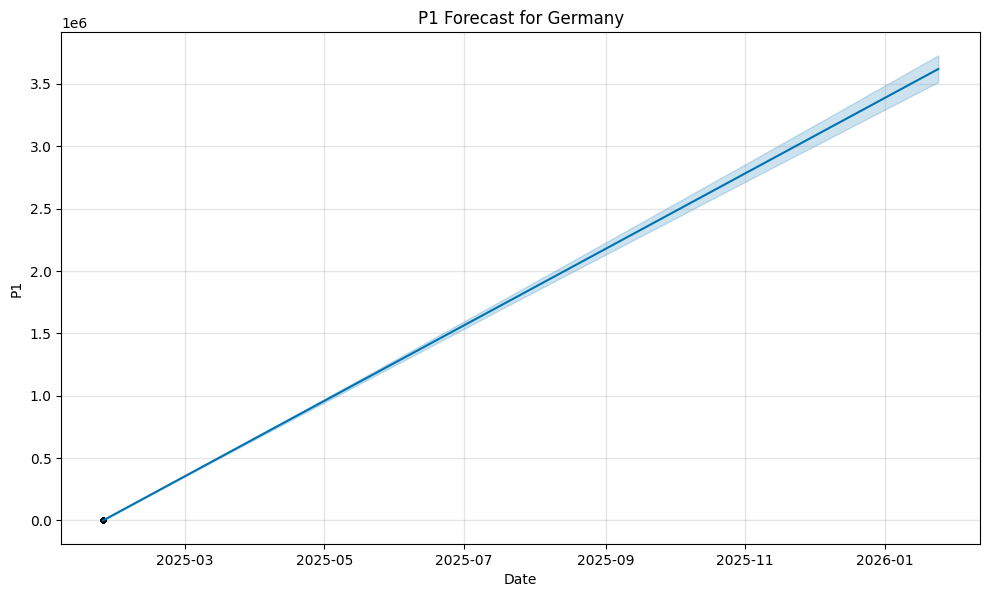

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, LongType, ArrayType
from pyspark.sql.functions import col, explode
import pandas as pd
from prophet import Prophet
import requests

# Create a SparkSession
spark = SparkSession.builder.appName("DataProcessing").getOrCreate()

# Define the schema for sensordatavalues
schema = StructType([
    StructField("id", LongType(), True),
    StructField("timestamp", StringType(), True),
    StructField("location", StructType([
        StructField("latitude", StringType(), True),
        StructField("longitude", StringType(), True),
        StructField("country", StringType(), True)
    ]), True),
    StructField("sensor", StructType([
        StructField("id", LongType(), True),
        StructField("sensor_type", StructType([
            StructField("name", StringType(), True),
            StructField("id", LongType(), True)
        ]), True)
    ]), True),
    StructField("sensordatavalues", ArrayType(StructType([
        StructField("value_type", StringType(), True),
        StructField("value", StringType(), True)  # Use StringType for 'value'
    ])), True),
    StructField("sampling_rate", StringType(), True)
])

# Fetch data from the URL
url_today = "https://data.sensor.community/static/v2/data.json"  # Using the 5-minute data for testing
try:
    response_today = requests.get(url_today)
    response_today.raise_for_status()  # Raise an exception for bad status codes
    data_today = response_today.json()
except requests.exceptions.RequestException as e:
    print(f"Error fetching data: {e}")

# Create global_df
global_df = spark.createDataFrame(data_today, schema=schema)

# Cast latitude and longitude to float after DataFrame creation
global_df = global_df.withColumn("latitude", global_df.location.latitude.cast('float')) \
    .withColumn("longitude", global_df.location.longitude.cast('float'))

# ... (Your plot_and_forecast_time_series function remains the same)

# Call the function to forecast
plot_and_forecast_time_series(global_df, country_code='DE', value_type='P1', periods=365)

In [ ]:
pip install fbprophet

  Using cached fbprophet-0.7.1.tar.gz (64 kB)
  Preparing metadata (setup.py) ... done
  Using cached cmdstanpy-0.9.5-py3-none-any.whl.metadata (2.9 kB)
  Using cached pystan-3.10.0-py3-none-any.whl.metadata (3.7 kB)
  Using cached LunarCalendar-0.0.9-py2.py3-none-any.whl.metadata (6.3 kB)
  Using cached convertdate-2.4.0-py3-none-any.whl.metadata (8.3 kB)
  Using cached setuptools_git-1.2-py2.py3-none-any.whl.metadata (5.8 kB)
  Using cached PyMeeus-0.5.12-py3-none-any.whl
  Using cached ephem-4.1.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.0 kB)
  Using cached clikit-0.6.2-py2.py3-none-any.whl.metadata (1.6 kB)
  Using cached httpstan-4.13.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.2 kB)
  Using cached pysimdjson-6.0.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.9 kB)
  Using cached crashtest-0.3.1-py3-none-any.whl.metadata (748 bytes)
  Using cached pastel-0.2.1-py2.py3-none-any.whl.metadata (1.9 k

In [ ]:
from fbprophet.plot import plot_plotly
import matplotlib.pyplot as plt

# Adjusted function to restore the original Prophet-like style
def plot_and_forecast_refined(df, country_code='DE', value_type='P1', periods=365):
    """Plots a Prophet-styled time series forecast with adjusted aesthetics."""
    # Convert Spark DataFrame to Pandas DataFrame
    pandas_df = df.filter(df.country == country_code).select('timestamp', value_type).toPandas()

    # Convert 'timestamp' column to datetime objects
    pandas_df['timestamp'] = pd.to_datetime(pandas_df['timestamp'])

    # Rename columns to fit Prophet's requirements
    pandas_df = pandas_df.rename(columns={'timestamp': 'ds', value_type: 'y'})

    # Create and fit Prophet model
    model = Prophet()
    model.fit(pandas_df)

    # Create future dataframe for forecasting
    future = model.make_future_dataframe(periods=periods)

    # Make predictions
    forecast = model.predict(future)

    # Prophet's default plot with Matplotlib refinements
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(pandas_df['ds'], pandas_df['y'], 'o', markersize=4, color='black', label='Actual Data')  # Adjust marker size
    ax.plot(forecast['ds'], forecast['yhat'], lw=1.5, color='blue', label='Forecast')  # Adjust line width

    # Refine appearance
    ax.set_title(f'{value_type} Forecast for {country_code}', fontsize=14)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel(value_type, fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend(fontsize=10)
    plt.tight_layout()

    # Show the plot
    plt.show()

# Call the refined function
plot_and_forecast_refined(spark_df, country_code='DE', value_type='P1', periods=365)


ModuleNotFoundError: No module named 'fbprophet'

In [ ]:
# Fetch data (replace with your actual data sources)
url_today = "https://data.sensor.community/static/v2/data.json"
url_yesterday = "https://data.sensor.community/static/v2/data.1h.json"

# Call question_1() to calculate AQI_today and AQI_yesterday
question_1()  # This will execute the function and define AQI_today and AQI_yesterday

# Get AQI data with continent information
def get_aqi_with_continent(aqi_data):
    # Convert AQI data to Pandas DataFrame
    aqi_df = aqi_data.toPandas()

    # Add country names and continents
    aqi_df['country_name'] = aqi_df['country'].apply(lambda x: pycountry.countries.get(alpha_2=x).name if pycountry.countries.get(alpha_2=x) else None)
    aqi_df['continent'] = aqi_df['country'].apply(lambda x: pycountry.countries.get(alpha_2=x).continent if pycountry.countries.get(alpha_2=x) else None)

    return aqi_df

aqi_today_with_continent = get_aqi_with_continent(AQI_today)
import matplotlib.pyplot as plt
import seaborn as sns

# Group by continent and get top 5 countries
for continent, group in aqi_today_with_continent.groupby('continent'):
    top_5 = group.sort_values(by=['AQI'], ascending=False).head(5)

    # Create bar graph
    plt.figure(figsize=(10, 6))
    sns.barplot(x='country_name', y='AQI', data=top_5)
    plt.title(f'Top 5 Countries with Highest AQI in {continent}')
    plt.xlabel('Country')
    plt.ylabel('AQI')
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.tight_layout()
    plt.show()

AttributeError: continent

In [ ]:
!pip install pyspark pandas pycountry requests matplotlib seaborn

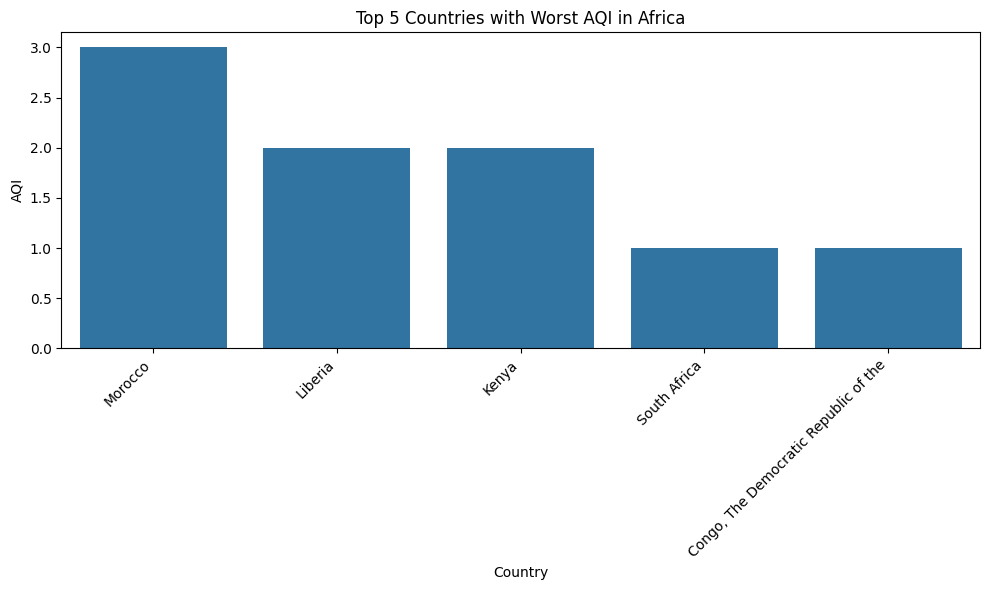

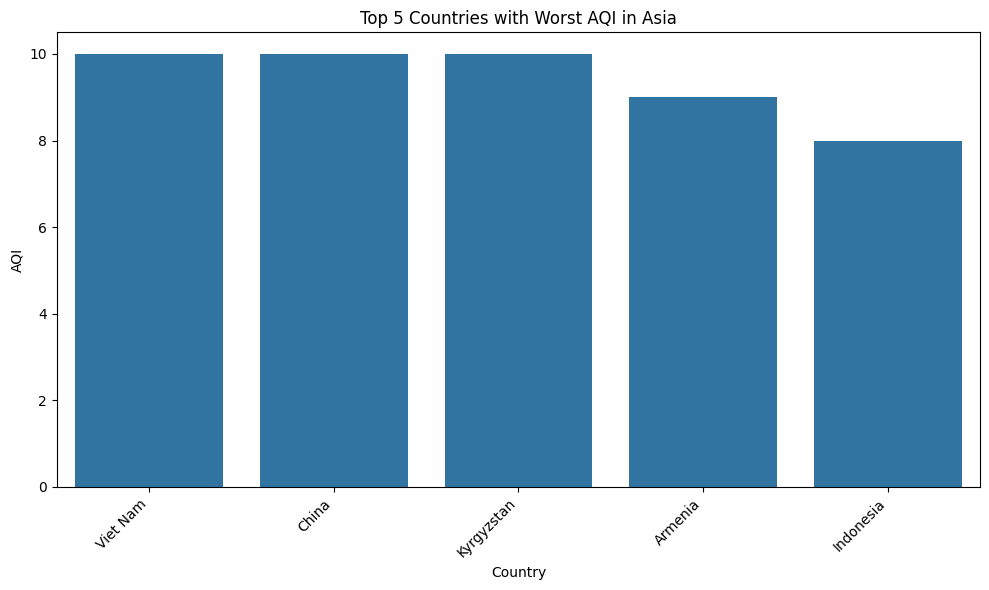

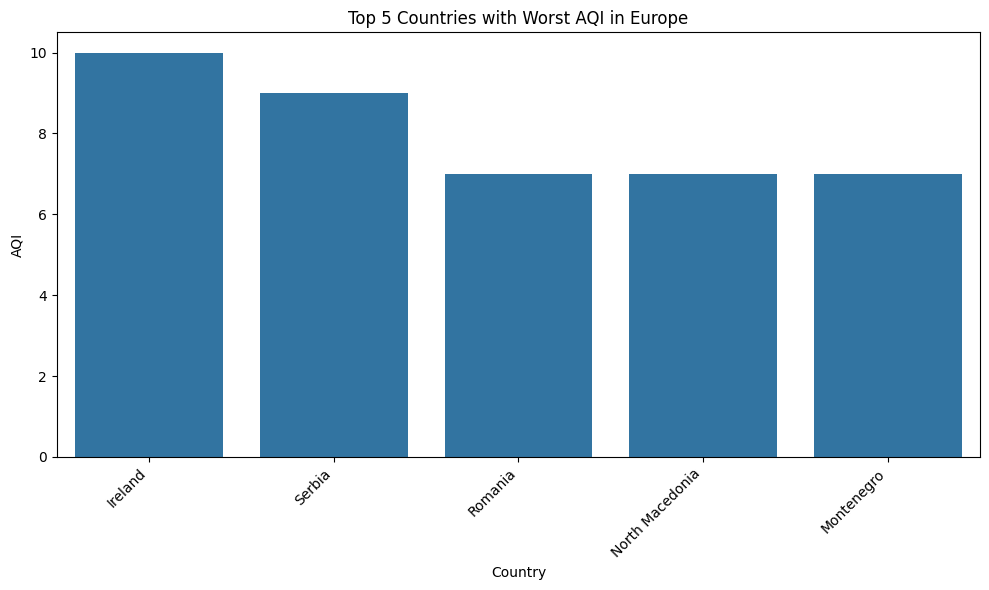

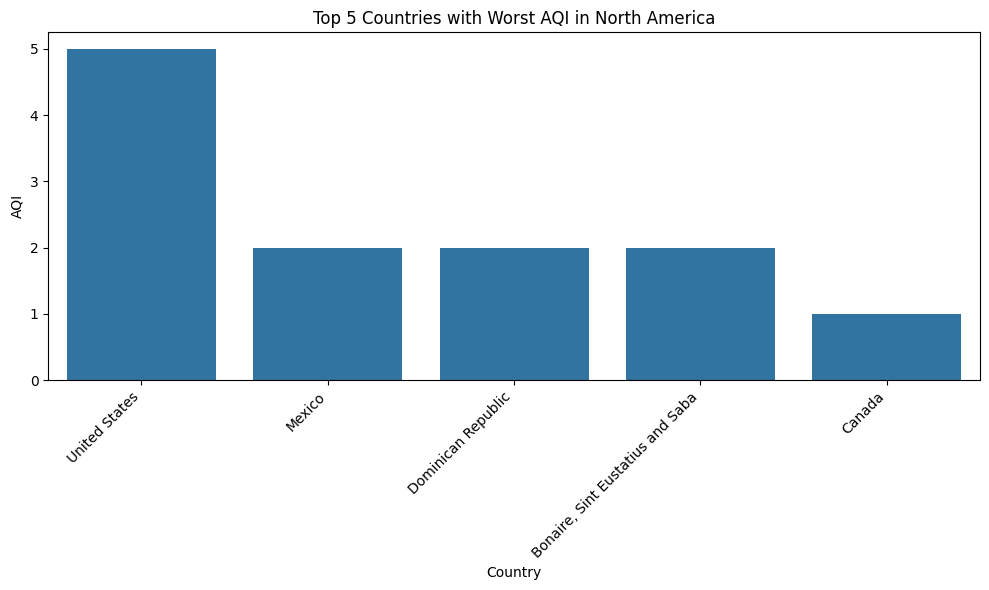

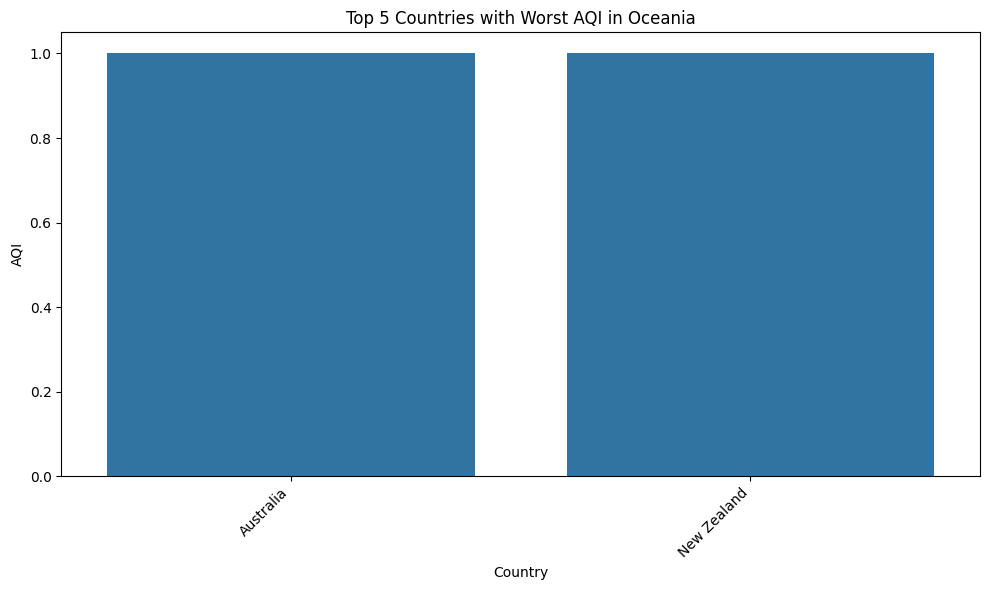

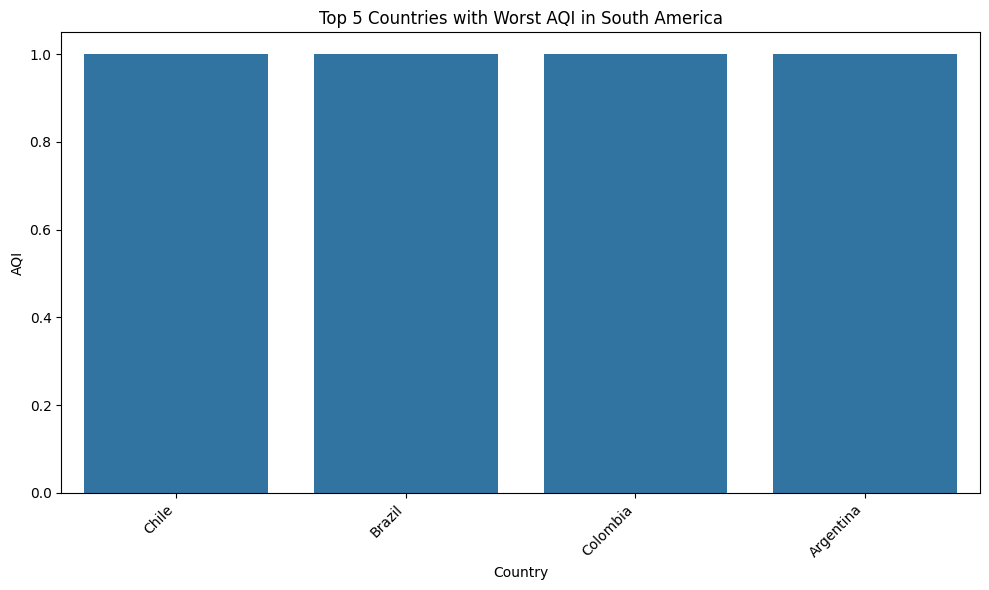

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, LongType, ArrayType
from pyspark.sql.functions import col, explode, ceil, when, monotonically_increasing_id
import pandas as pd
import pycountry
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# ... other imports as needed (e.g., folium, geopandas, etc.)

# Create a SparkSession (if not already created)
spark = SparkSession.builder.appName("DataProcessing").getOrCreate()

# Functions from question_1() (data_process, compute_AQI_per_country, AQI_improvementPerCountry, etc.)
# ... (Paste the function definitions here)

# Your current code:
# Fetch data (replace with your actual data sources)
url_today = "https://data.sensor.community/static/v2/data.json"
url_yesterday = "https://data.sensor.community/static/v2/data.1h.json"

try:
    response_today = requests.get(url_today)
    response_today.raise_for_status()  # Raise an exception for bad status codes
    data_today = response_today.json()

    response_yesterday = requests.get(url_yesterday)
    response_yesterday.raise_for_status()
    data_yesterday = response_yesterday.json()
except requests.exceptions.RequestException as e:
    print(f"Error fetching data: {e}")

# Define the schema for sensordatavalues (same as in question_1())
schema = StructType([
    StructField("id", LongType(), True),
    StructField("timestamp", StringType(), True),
    StructField("location", StructType([
        StructField("latitude", StringType(), True),
        StructField("longitude", StringType(), True),
        StructField("country", StringType(), True)
    ]), True),
    StructField("sensor", StructType([
        StructField("id", LongType(), True),
        StructField("sensor_type", StructType([
            StructField("name", StringType(), True),
            StructField("id", LongType(), True)
        ]), True)
    ]), True),
    StructField("sensordatavalues", ArrayType(StructType([
        StructField("value_type", StringType(), True),
        StructField("value", StringType(), True)  # Use StringType for 'value'
    ])), True),
    StructField("sampling_rate", StringType(), True)
])

# Create Spark DataFrames with the defined schema
df_today = spark.createDataFrame(data_today, schema=schema)
df_yesterday = spark.createDataFrame(data_yesterday, schema=schema)

# Cast latitude and longitude to float after DataFrame creation
df_today = df_today.withColumn("latitude", df_today.location.latitude.cast('float'))\
                   .withColumn("longitude", df_today.location.longitude.cast('float'))
df_yesterday = df_yesterday.withColumn("latitude", df_yesterday.location.latitude.cast('float'))\
                   .withColumn("longitude", df_yesterday.location.longitude.cast('float'))


# Calculate AQI_today (from question_1())
AQI_today = compute_AQI_per_country(data_process(df_today))


import pycountry_convert as pc

def get_aqi_with_continent(aqi_data):
    # Convert AQI data to Pandas DataFrame
    aqi_df = aqi_data.toPandas()

    # Add country names and continents
    aqi_df['country_name'] = aqi_df['country'].apply(lambda x: pycountry.countries.get(alpha_2=x).name if pycountry.countries.get(alpha_2=x) else None)

    # Get continent code and then continent name using pycountry_convert
    aqi_df['continent'] = aqi_df['country'].apply(lambda x: pc.country_alpha2_to_continent_code(x)
                                                 if pycountry.countries.get(alpha_2=x) else None)
    aqi_df['continent'] = aqi_df['continent'].apply(lambda x: pc.convert_continent_code_to_continent_name(x)
                                                 if x else None)

    return aqi_df

aqi_today_with_continent = get_aqi_with_continent(AQI_today)

# Group by continent and get top 5 countries
for continent, group in aqi_today_with_continent.groupby('continent'):
    top_5 = group.sort_values(by=['AQI'], ascending=False).head(5)

    # Create bar graph
    plt.figure(figsize=(10, 6))
    sns.barplot(x='country_name', y='AQI', data=top_5)
    plt.title(f'Top 5 Countries with Worst AQI in {continent}')
    plt.xlabel('Country')
    plt.ylabel('AQI')
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.tight_layout()
    plt.show()

In [ ]:
!pip install pycountry_convert

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.8/239.8 kB 5.9 MB/s eta 0:00:00
